# **Atividade 3 - Uso de Redes Neurais Convolucionais para Detecção de Mudanças**

## **Disciplina:** CAP-421-3 Aprendizado Profundo

**Discintes:**

Gabriel Sansigolo

### **Importando bibliotecas**

In [1]:
import numpy as np 
import pandas as pd
import os
import torch
import torch.nn as nn
from tqdm  import tqdm
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from PIL import Image
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

c:\Users\Sansigolo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Utiliza GPU (cuda), caso contrário, utiliza CPU**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else'cpu') 

In [3]:
cuda_id = torch.cuda.current_device()
torch.cuda.get_device_name(cuda_id)

'NVIDIA GeForce RTX 4080'

### **1 - Carrega os Dados de Treinamento, Teste e Validação**

A primeira etapa, denominada Carrega os Dados de Treinamento, Teste e Validação, nela é definida todas as três lista de imagens dos três tipos de dados treinamento, teste e validação. Esse trecho recebe como o caminho da pasta onde deve ser aberta as imagens. Nela é percorrido todos os arquivos da pasta definida e arquivo por arquivo (imagens) é appendido a linha com o caminho da imagem em uma lista. Isso é feito para todas as imagens.

In [4]:
input_path = os.path.dirname("")

img1 = []   
img2 = []   
label = []  

path = os.path.join(input_path,'trainmod/time1/')
filenames = os.listdir(path)

for filename in tqdm(filenames):
    img1.append(os.path.join(input_path,'trainmod/time1/'+ filename))
    img2.append(os.path.join(input_path,'trainmod/time2/'+ filename))
    label.append(os.path.join(input_path,'trainmod/label/'+ filename))

100%|██████████| 6000/6000 [00:00<00:00, 415661.73it/s]


In [5]:
test_img1 = []   
test_img2 = []   
test_label = []  

path = os.path.join(input_path,'testmod/time1/')
filenames = os.listdir(path)

for filename in tqdm(filenames):
    test_img1.append(os.path.join(input_path,'testmod/time1/'+ filename))
    test_img2.append(os.path.join(input_path,'testmod/time2/'+ filename))
    test_label.append(os.path.join(input_path,'testmod/label/'+ filename))

100%|██████████| 1000/1000 [00:00<00:00, 334154.24it/s]


In [6]:
val_img1 = []   
val_img2 = []   
val_label = []  

path = os.path.join(input_path,'valmod/time1/')
filenames = os.listdir(path)

for filename in tqdm(filenames):
    val_img1.append(os.path.join(input_path,'valmod/time1/'+ filename))
    val_img2.append(os.path.join(input_path,'valmod/time2/'+ filename))
    val_label.append(os.path.join(input_path,'valmod/label/'+ filename))

100%|██████████| 1000/1000 [00:00<00:00, 331906.62it/s]


#### **1.5 - Plota um Exemplo Aleatorio dos Dados de Treinamento**

A etapa 1.5, denominada Plota um Exemplo Aleatorio dos Dados de Treinamento, nela é aberto um exemplo (aleatorio) de imagem de treinamento usando a biblioteca pillow Python Imaging Library (PIL). Isso é feito para verificar se os dados estão certos

(256, 256, 2)


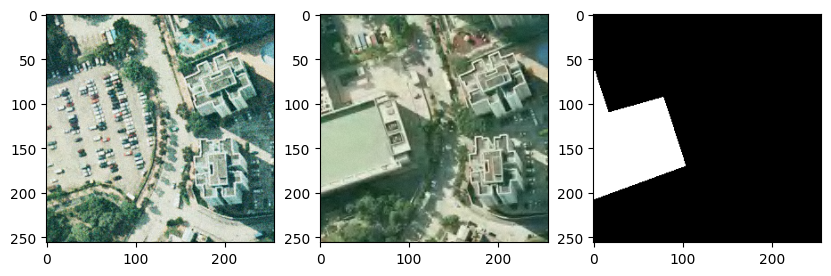

In [7]:
sample = np.random.randint(0,6000) # generate a random number    

im1 = Image.open(img1[sample])
im2 = Image.open(img2[sample])
lab = Image.open(label[sample]).convert('LA')
print(np.array(lab).shape)
fig,ax = plt.subplots(1,3,figsize=(10,10))
ax[0].imshow(im1)
ax[1].imshow(im2)
ax[2].imshow(lab)

### **2 - Cria Panda DataFrame com os Dados de Treinamento, Teste e Validação**

A segunda etapa, denominada Cria Panda DataFrame com os Dados de Treinamento, Teste e Validação, nela é executado um for em cada uma das três fontes de dados treinamento, teste e validação e para cada uma delas é recortado da lista em grupos de 64 (batchs) e cadastrado em um panda dataframe.


In [8]:
path1 = []
path2 = []
target = []
start_row = []
end_row = []
start_col = []
end_col = []

for im1,im2,lab in zip(img1,img2,label):
    for row in [0,64,128,192]:
        for col in [0,64,128,192]:
            row_start = row
            row_end = row + 64
            col_start = col
            col_end = col + 64
            
            path1.append(im1)
            path2.append(im2)
            target.append(lab)
            
            start_row.append(row_start)
            end_row.append(row_end)
            
            start_col.append(col_start)
            end_col.append(col_end)
            
df = pd.DataFrame({"path1":path1,"path2":path2,"target":target,"start_row":start_row,"end_row":end_row,"start_col":start_col,"end_col":end_col})
df

,path1,path2,target,start_row,end_row,start_col,end_col
0,trainmod/time1/00000.png,trainmod/time2/00000.png,trainmod/label/00000.png,0,64,0,64
1,trainmod/time1/00000.png,trainmod/time2/00000.png,trainmod/label/00000.png,0,64,64,128
2,trainmod/time1/00000.png,trainmod/time2/00000.png,trainmod/label/00000.png,0,64,128,192
3,trainmod/time1/00000.png,trainmod/time2/00000.png,trainmod/label/00000.png,0,64,192,256
4,trainmod/time1/00000.png,trainmod/time2/00000.png,trainmod/label/00000.png,64,128,0,64
...,...,...,...,...,...,...,...
95995,trainmod/time1/05999.png,trainmod/time2/05999.png,trainmod/label/05999.png,128,192,192,256
95996,trainmod/time1/05999.png,trainmod/time2/05999.png,trainmod/label/05999.png,192,256,0,64
95997,trainmod/time1/05999.png,trainmod/time2/05999.png,trainmod/label/05999.png,192,256,64,128
95998,trainmod/time1/05999.png,trainmod/time2/05999.png,trainmod/label/05999.png,192,256,128,192


In [9]:
path1 = []
path2 = []
target = []
start_row = []
end_row = []
start_col = []
end_col = []

for im1,im2,lab in zip(test_img1,test_img2,test_label):
    for row in [0,64,128,192]:
        for col in [0,64,128,192]:
            row_start = row
            row_end = row + 64
            col_start = col
            col_end = col + 64
            
            path1.append(im1)
            path2.append(im2)
            target.append(lab)
            
            start_row.append(row_start)
            end_row.append(row_end)
            
            start_col.append(col_start)
            end_col.append(col_end)
            
test_df = pd.DataFrame({"path1":path1,"path2":path2,"target":target,"start_row":start_row,"end_row":end_row,"start_col":start_col,"end_col":end_col})
test_df

,path1,path2,target,start_row,end_row,start_col,end_col
0,testmod/time1/00000.png,testmod/time2/00000.png,testmod/label/00000.png,0,64,0,64
1,testmod/time1/00000.png,testmod/time2/00000.png,testmod/label/00000.png,0,64,64,128
2,testmod/time1/00000.png,testmod/time2/00000.png,testmod/label/00000.png,0,64,128,192
3,testmod/time1/00000.png,testmod/time2/00000.png,testmod/label/00000.png,0,64,192,256
4,testmod/time1/00000.png,testmod/time2/00000.png,testmod/label/00000.png,64,128,0,64
...,...,...,...,...,...,...,...
15995,testmod/time1/00999.png,testmod/time2/00999.png,testmod/label/00999.png,128,192,192,256
15996,testmod/time1/00999.png,testmod/time2/00999.png,testmod/label/00999.png,192,256,0,64
15997,testmod/time1/00999.png,testmod/time2/00999.png,testmod/label/00999.png,192,256,64,128
15998,testmod/time1/00999.png,testmod/time2/00999.png,testmod/label/00999.png,192,256,128,192


In [10]:
path1 = []
path2 = []
target = []
start_row = []
end_row = []
start_col = []
end_col = []

for im1,im2,lab in zip(val_img1,val_img2,val_label):
    for row in [0,64,128,192]:
        for col in [0,64,128,192]:
            row_start = row
            row_end = row + 64
            col_start = col
            col_end = col + 64
            
            path1.append(im1)
            path2.append(im2)
            target.append(lab)
            
            start_row.append(row_start)
            end_row.append(row_end)
            
            start_col.append(col_start)
            end_col.append(col_end)
            
val_df = pd.DataFrame({"path1":path1,"path2":path2,"target":target,"start_row":start_row,"end_row":end_row,"start_col":start_col,"end_col":end_col})
val_df

,path1,path2,target,start_row,end_row,start_col,end_col
0,valmod/time1/12000.png,valmod/time2/12000.png,valmod/label/12000.png,0,64,0,64
1,valmod/time1/12000.png,valmod/time2/12000.png,valmod/label/12000.png,0,64,64,128
2,valmod/time1/12000.png,valmod/time2/12000.png,valmod/label/12000.png,0,64,128,192
3,valmod/time1/12000.png,valmod/time2/12000.png,valmod/label/12000.png,0,64,192,256
4,valmod/time1/12000.png,valmod/time2/12000.png,valmod/label/12000.png,64,128,0,64
...,...,...,...,...,...,...,...
15995,valmod/time1/12999.png,valmod/time2/12999.png,valmod/label/12999.png,128,192,192,256
15996,valmod/time1/12999.png,valmod/time2/12999.png,valmod/label/12999.png,192,256,0,64
15997,valmod/time1/12999.png,valmod/time2/12999.png,valmod/label/12999.png,192,256,64,128
15998,valmod/time1/12999.png,valmod/time2/12999.png,valmod/label/12999.png,192,256,128,192


### **3 - Definição da Classe**

A terceira etapa, denominada Definição da Classe, essa etapa é definida a função que será usada para trabalhar com os dados. Denominada ChangeDataset essa classe python possuí três principais funções init, len e getitem. Ela existe para facilitar manipulação dos dados de treinamento e teste durante o processo.

In [12]:
class ChangeDataset():
    def __init__(self,df):
        self.df = df
        
    def __len__(self):
        return (len(self.df))
    
    def __getitem__(self,item):
        im1 = Image.open(self.df.loc[item,"path1"])
        im1 = np.array(im1.resize((256,256))) / 255 
        im2 = Image.open(self.df.loc[item,"path2"])
        im2 = np.array(im2.resize((256,256))) / 255 
        target = Image.open(self.df.loc[item,"target"]).convert("RGB")
        target = np.array(target.resize((256,256))) 
        target = (np.mean(target,axis=-1) > 0.5).astype(np.uint8)
        start_row = self.df.loc[item,"start_row"]
        end_row = self.df.loc[item,"end_row"]
        start_col = self.df.loc[item,"start_col"]
        end_col = self.df.loc[item,"end_col"]
        
        im1 = torch.tensor(im1[start_row:end_row,start_col:end_col,:].transpose(2,1,0),dtype=torch.float)
        im2 = torch.tensor(im2[start_row:end_row,start_col:end_col,:].transpose(2,1,0),dtype=torch.float)
        target = torch.tensor(target[start_row:end_row,start_col:end_col],dtype=torch.long)
        
        return (im1,im2,target)

### **4 - Criação do Dataset Treinamento, Teste e Validação**


A quarta etapa, denominada Criação do Dataset Treinamento, Teste e Validação, essa etapa é aplciada a função ChangeDataset nos dataframes pandas para cada um dos três tipos de dados treinamento, teste e validação.

In [13]:
train_ds = ChangeDataset(df) 
test_ds = ChangeDataset(test_df)  
val_ds = ChangeDataset(val_df)  

### **5 - Verificação dos Dados**

A quinta etapa, denominada Verificação dos Dados, aqui é selecionado um exemplo (random) e printado usando nunpy vindo do dataset

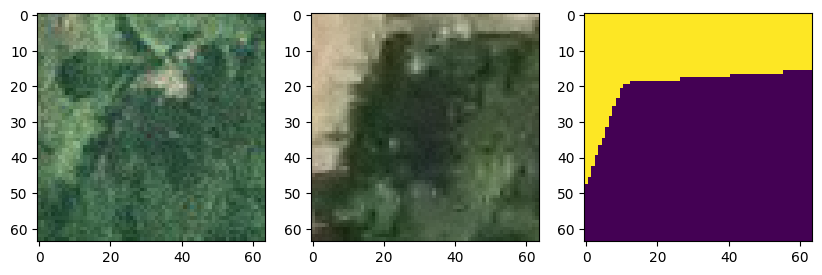

In [ ]:
sample = np.random.randint(0,6000) 

im1,im2,target = train_ds[sample] 
im1.shape,im2.shape,target.shape  

fig,ax = plt.subplots(1,3,figsize=(10,10))
ax[0].imshow(im1.numpy().transpose(1,2,0))
ax[1].imshow(im2.numpy().transpose(1,2,0))
ax[2].imshow(target.numpy())

### **6 - Criação dos DataLoaders para os Dados de Treinamento e Teste**

A sexta etapa, denominada Criação dos DataLoaders para os Dados de Treinamento e Test, essa etapa é definida pela criação dos objetos DataLoaders, um Dataset armazena as amostras e seus rótulos correspondentes, e o DataLoaders envolve um iterável em torno do Dataset para permitir fácil acesso às amostras.

In [ ]:
train_dl = DataLoader(train_ds,batch_size=64) 
val_dl = DataLoader(val_ds,batch_size=64) 

### **7 - Definindo a Rede Neural Convolucional (Unet) ChangeNet para Detecção de Mudança**

Após pesquisas foi concluido que uma bom modelo para resolver o problema seria baseado na arquitetura Unet com um codificador resnet34

In [ ]:
model = smp.Unet('resnet34', encoder_depth=3,decoder_channels=(64, 64, 16)) 

In [ ]:
class ChangeNet(nn.Module):
    def __init__(self,model):
        super().__init__()
        self.encoder = model.encoder  
        self.decoder = model.decoder  
        self.head = model.segmentation_head  
        
    def forward(self,x1,x2):
        enc1 = self.encoder(x1) 
        enc2 = self.encoder(x2)  
        encoder_out = []
        for i in range(len(enc1)):
            encoder_out.append(torch.add(enc1[i],enc2[i])) 
        decoder_out = self.decoder(*encoder_out) 
        out = self.head(decoder_out) 
        return out

In [ ]:
change_model = ChangeNet(model).to(device) 

### **8 - Definição da Função de Perda e do Otimizador**

A oitava etapa, denominada Definição da FUnção de Perda e do Otimizador. Nela decidiu usar a função de perda, BCE, pois é classificação binária 

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss().to(device)   
optimizer = torch.optim.Adam(change_model.parameters(), lr=0.0001)

### **10 - Treinamento da ChangeNet e Avaliação do Desempenho**

A decima etapa, denominada Treinamento da ChangeNet e Avaliação do Desempenho, se conside em executar dez épocas de treinamento e para cada época rm batchs e para cada época calculado a perda.

In [22]:
for epoch in tqdm(range(10)): 
    epoch_loss = []
        
    change_model.train() 
    for x1,x2,target_o in tqdm(train_dl,total=len(train_dl)):
        x1 = x1.to(device)  
        x2 = x2.to(device)  
        target = target_o.to(device) 
                
        optimizer.zero_grad()   

        outputs = change_model(x1,x2)  
        
        loss = criterion(outputs.squeeze(), target.float()) 

        loss.backward()  
        optimizer.step()  
        epoch_loss.append(loss.item())
    
    print(f"Epoch {epoch}, Loss:",np.array(epoch_loss).mean())

 10%|█         | 1/10 [18:47<2:49:09, 1127.77s/it]

Epoch 0, Loss: 0.43050553555289905


 20%|██        | 2/10 [29:52<1:54:03, 855.43s/it] 

Epoch 1, Loss: 0.35964524978895984


 30%|███       | 3/10 [46:47<1:48:16, 928.09s/it]

Epoch 2, Loss: 0.3252914886921644


 40%|████      | 4/10 [59:58<1:27:24, 874.08s/it]

Epoch 3, Loss: 0.30217584263285


 50%|█████     | 5/10 [1:15:50<1:15:11, 902.32s/it]

Epoch 4, Loss: 0.28392965023964645


 60%|██████    | 6/10 [1:32:15<1:02:01, 930.28s/it]

Epoch 5, Loss: 0.26769173674533764


 70%|███████   | 7/10 [1:46:45<45:32, 910.75s/it]  

Epoch 6, Loss: 0.25159637704243265


 80%|████████  | 8/10 [2:01:51<30:18, 909.20s/it]

Epoch 7, Loss: 0.23666293932000795


 90%|█████████ | 9/10 [2:20:16<16:10, 970.29s/it]

Epoch 8, Loss: 0.2210794023896257


100%|██████████| 10/10 [2:34:18<00:00, 925.85s/it]

Epoch 9, Loss: 0.2041447216384113


### **10.5 - Salvando o modelo treinado**

A 10.5 etapa, denominada Salvando o modelo treinado, existe por que foi solicitado no exercico salvar o modelo treinado em formato arquivo.

In [25]:
input_path = os.path.dirname("")

torch.save(model.state_dict(), os.path.join(input_path,'model.pth'))

### **11 - Teste da rede**

A decima primeira e última etapa, Teste da rede, se consiste em executar o modelo treinado sobre os dados de teste e teste a teste comparar a mascara gerada pelo modelo comparando ela com a a verdade

In [26]:
change_model.eval()  

ChangeNet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [27]:
images = []
prediction_masks = []
truth_masks = []
iou_scores = []
f1_scores = []

with torch.no_grad():
    for s in tqdm(range(len(test_ds))):
        
        pred_mask = (torch.sigmoid(change_model(test_ds[s][0].unsqueeze(dim=0).to(device),test_ds[s][1].unsqueeze(dim=0).to(device))).squeeze()).detach().cpu().numpy()  
        pred_mask = (np.rint(pred_mask)).astype(int)

        images.append([test_ds[s][0].numpy(), test_ds[s][1].numpy()])
        prediction_masks.append(pred_mask)
        truth_masks.append(test_ds[s][2].numpy())

        intersection = np.logical_and(truth_masks[s], prediction_masks[s])
        union = np.logical_or(truth_masks[s], prediction_masks[s])
        iou = np.sum(intersection) / np.sum(union) if np.sum(intersection) != 0 and np.sum(union) != 0 else 1.0 #se a mascara for igual a verdade define 1.0 
        iou_scores.append(iou)
        
        f1 = f1_score(truth_masks[s], prediction_masks[s], average='weighted', zero_division=0)
        f1 = f1 if f1 != 0 else 1.0 #se a mascara for igual ao original define 1.0 
        f1_scores.append(f1)

100%|██████████| 16000/16000 [13:21<00:00, 19.98it/s]


### **11.2 - Calcula F1 Score**

In [28]:
f1_sc = np.sum(f1_scores)/len(test_ds)

print('F1-score is %s' % f1_sc)

F1-score is 0.8788725004915929


### **11.4 - Calcula IOU Score**

In [29]:
iou_score = np.sum(iou_scores)/len(test_ds)

print('IoU is %s' % iou_score)

IoU is 0.8560224025793418


### **11.6 - Printa exemplos lado a lado mascara gerada pelo modelo e verdade**

0.828080229226361

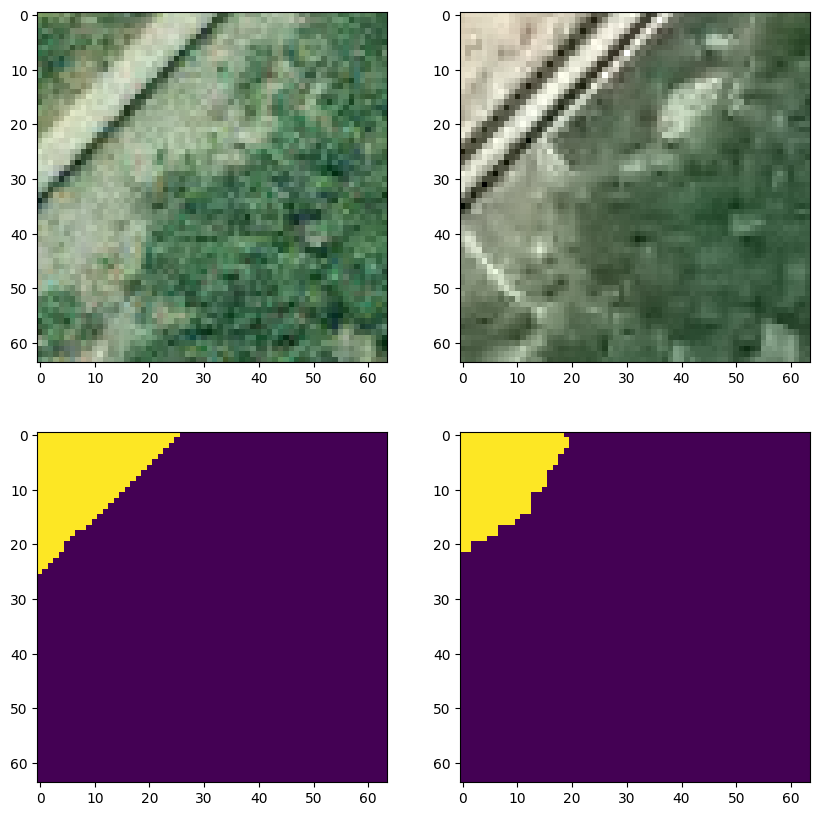

In [80]:
sample = np.random.randint(12000,16000) 

fig,ax = plt.subplots(2,2,figsize=(10,10))
ax[0][0].imshow(images[sample][0].transpose(1,2,0))
ax[0][1].imshow(images[sample][1].transpose(1,2,0))
ax[1][0].imshow(truth_masks[sample])
ax[1][1].imshow(prediction_masks[sample])

intersection = np.logical_and(truth_masks[sample], prediction_masks[sample])
union = np.logical_or(truth_masks[sample], prediction_masks[sample])
np.sum(intersection) / np.sum(union) if np.sum(intersection) != 0 and np.sum(union) != 0 else 1.0

0.8050391389432485

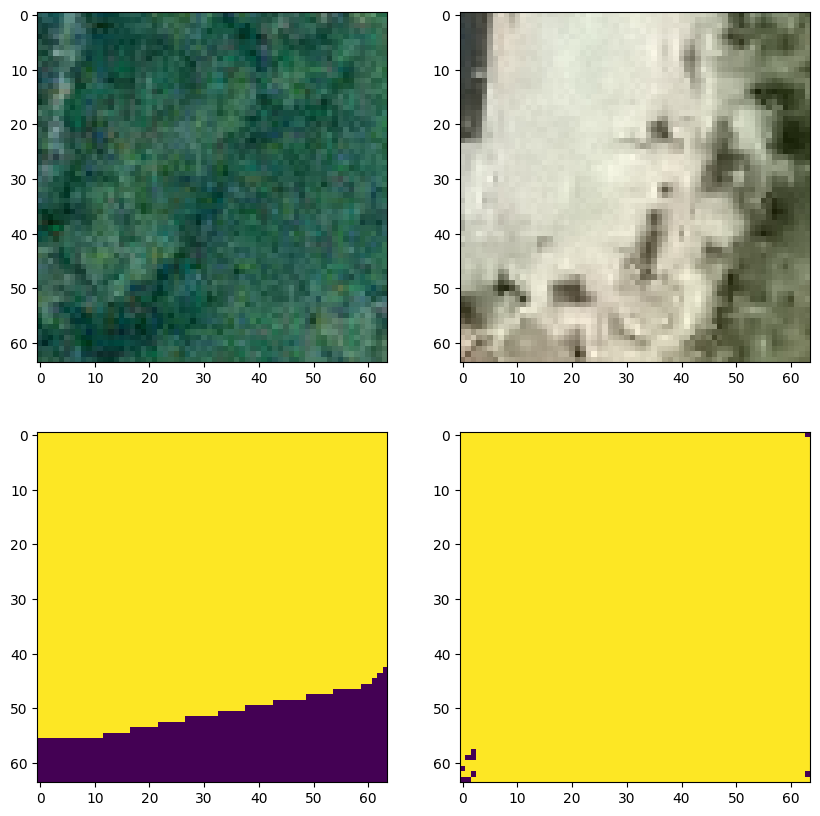

In [81]:
sample = np.random.randint(0,4000) 

fig,ax = plt.subplots(2,2,figsize=(10,10))
ax[0][0].imshow(images[sample][0].transpose(1,2,0))
ax[0][1].imshow(images[sample][1].transpose(1,2,0))
ax[1][0].imshow(truth_masks[sample])
ax[1][1].imshow(prediction_masks[sample])

intersection = np.logical_and(truth_masks[sample], prediction_masks[sample])
union = np.logical_or(truth_masks[sample], prediction_masks[sample])
np.sum(intersection) / np.sum(union) if np.sum(intersection) != 0 and np.sum(union) != 0 else 1.0

0.620049504950495

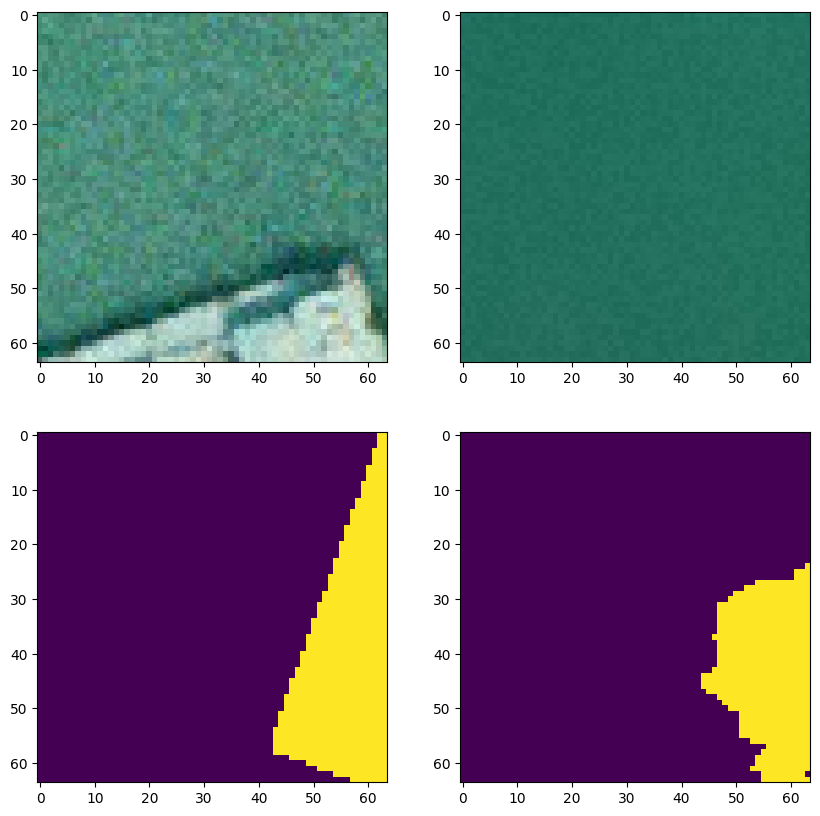

In [84]:
sample = np.random.randint(6000,8000) 

fig,ax = plt.subplots(2,2,figsize=(10,10))
ax[0][0].imshow(images[sample][0].transpose(1,2,0))
ax[0][1].imshow(images[sample][1].transpose(1,2,0))
ax[1][0].imshow(truth_masks[sample])
ax[1][1].imshow(prediction_masks[sample])

intersection = np.logical_and(truth_masks[sample], prediction_masks[sample])
union = np.logical_or(truth_masks[sample], prediction_masks[sample])
np.sum(intersection) / np.sum(union) if np.sum(intersection) != 0 and np.sum(union) != 0 else 1.0

### **11.8 - Conclusão**

O modelo apresentou resultado interessantes porém vendo exemplos lado a lado da mascara gerada pelo modelo observa-se que o modelo apesar do bom score ainda apresentou problemas na detecção. Após execução do problema observou-se a falta de rodar dados de validação durante o treinamento para calculo da acuracia por época, isso foi feito porém removido durante a última execução (por esquecimento).